# MNIST Text Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data

In [ ]:
data_dir = './data'
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

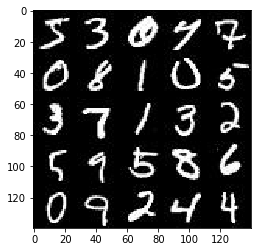

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/apil.tamang/anaconda3/envs/tensorflow_dlrtp/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [ ]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim))
    learn_rate = tf.placeholder(dtype=tf.float32, shape=(None))
    return input_real, input_z, learn_rate

tests.test_model_inputs(model_inputs)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    
    alpha = 0.9    
    is_training = True # for the discriminator, batch_normalization is always set on training mode
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # input: 28 * 28 * num_channels    
        x = tf.layers.conv2d(inputs=images, filters=32, kernel_size=5, strides=2, activation=None, padding='same')
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)

        # input: 14 * 14 * 32    
        x = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, activation=None, padding='same')
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)

        x = tf.reshape(tensor=x, shape=(-1, 7*7*64))
        x = tf.layers.dense(inputs=x, units=1, activation=None)
        logits = tf.sigmoid(x)
        
        return x, logits


tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, reuse=False, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.9

    with tf.variable_scope("generator", reuse=reuse):
        
        # connect random input z to a dense layer
        x = tf.layers.dense(inputs=z, units=7*7*64, activation=None)

        # apply batch normalization and leaky relu activation
        x = tf.reshape(x, shape=(-1, 7, 7, 64))
        x = tf.layers.batch_normalization(inputs=x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # input: 7*7*64 
        x = tf.layers.conv2d_transpose(inputs=x, filters=32, activation=None, kernel_size=5, strides=2, padding='same')
        x = tf.layers.batch_normalization(inputs=x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # output: 14 *14*32
        
        # input: 14*14*32 
        x = tf.layers.conv2d_transpose(inputs=x, filters=out_channel_dim, activation=None, kernel_size=5, strides=2, padding='same')
        # output: 28*28*out_channel_dim
        
        # rescale output using tanh
        g_model = tf.tanh(x)
        
        return g_model


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(z = input_z, out_channel_dim=out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(images=input_real)
    d_model_fake, d_logits_fake = discriminator(images=g_model, reuse=True)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    all_vars = [v for v in tf.trainable_variables() ]
    g_vars = [v for v in all_vars if v.name.startswith('generator')]
    d_vars = [v for v in all_vars if v.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        return d_opt, g_opt


tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, reuse=True, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """


    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=data_shape[3])    
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss, beta1=beta1, learning_rate=learning_rate)
    
    show_fig_every_batch = 100
    show_loss_every_batch = 50
    
    num_channels = data_shape[3]
    show_images = 16
    random_constant_z = tf.random_uniform(dtype=tf.float32, minval=-1, maxval=1, shape=(show_images,z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):

            batch_num = 0
            for batch_images in get_batches(batch_size):
                
                batch_num +=1
                sample_z = np.random.uniform(high=1, low=-1, size=[batch_size, z_dim])                
                
                _ , discr_loss = sess.run([d_opt, d_loss], feed_dict={input_real: batch_images, input_z: sample_z})
                
                _ , gener_loss = sess.run([g_opt, g_loss], feed_dict={input_real: batch_images, input_z: sample_z}) 

                if(batch_num%show_loss_every_batch == 0 ):
                    print("discriminator loss: ", discr_loss, "generator loss: ", gener_loss)
                
                if(batch_num%show_loss_every_batch == 0):
                    show_generator_output(sess=sess, n_images=show_images, input_z=random_constant_z, out_channel_dim=1, image_mode='L')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

### NOTE:
The output of this GAN model isn't very nice... i.e. the generator's and discriminator's loss seem to saturate at some point, and the images produced by the GAN isn't so nice.

In [11]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

discriminator loss:  1.42119 generator loss:  0.42596


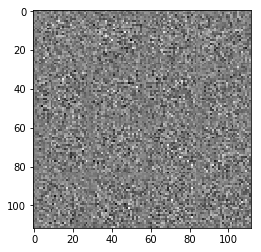

discriminator loss:  1.3007 generator loss:  0.503239


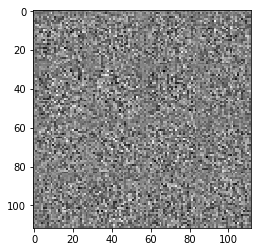

discriminator loss:  1.18451 generator loss:  0.568491


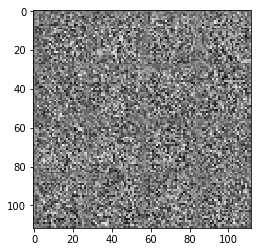

discriminator loss:  1.12835 generator loss:  0.608539


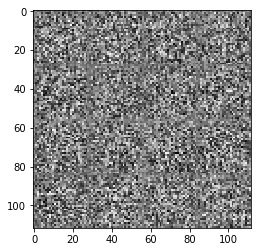

discriminator loss:  1.10923 generator loss:  0.6241


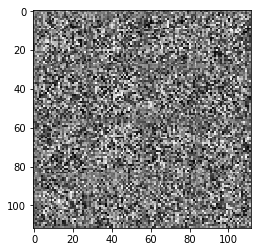

discriminator loss:  1.06148 generator loss:  0.653738


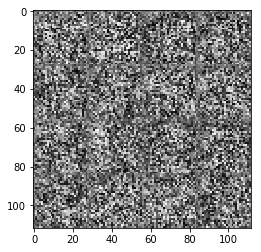

discriminator loss:  1.03904 generator loss:  0.667517


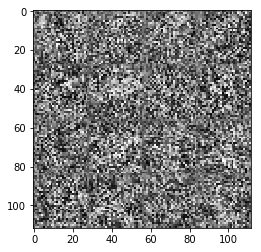

discriminator loss:  1.02673 generator loss:  0.676692


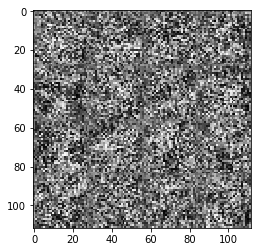

discriminator loss:  1.02414 generator loss:  0.679797


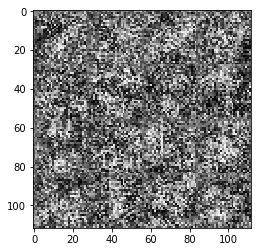

discriminator loss:  1.02057 generator loss:  0.682666


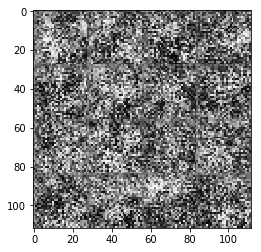

discriminator loss:  1.01763 generator loss:  0.685729


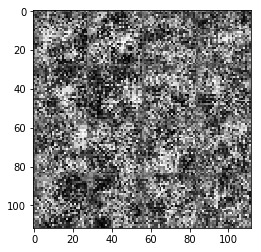

discriminator loss:  1.01705 generator loss:  0.685417


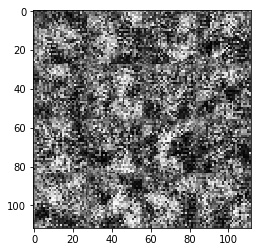

discriminator loss:  1.01388 generator loss:  0.68831


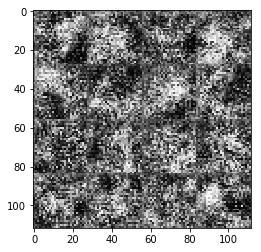

discriminator loss:  1.0132 generator loss:  0.688434


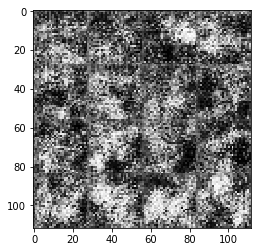

discriminator loss:  1.01463 generator loss:  0.688355


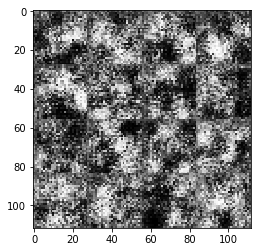

discriminator loss:  1.01121 generator loss:  0.689828


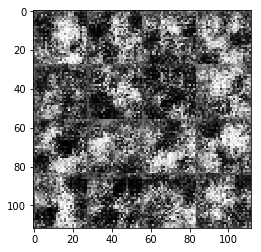

discriminator loss:  1.01187 generator loss:  0.690014


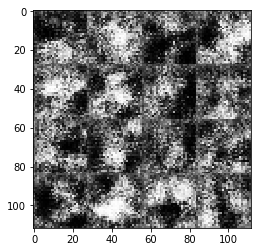

discriminator loss:  1.00972 generator loss:  0.691011


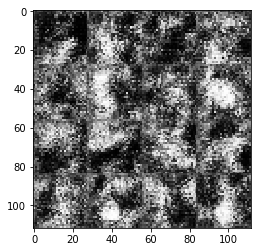

discriminator loss:  1.00933 generator loss:  0.691341


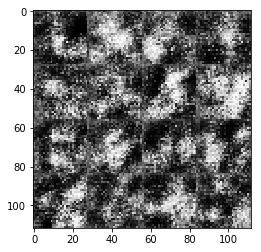

discriminator loss:  1.00828 generator loss:  0.691942


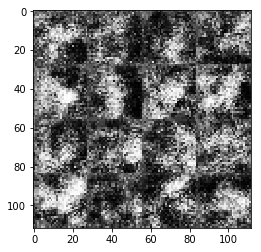

discriminator loss:  1.00853 generator loss:  0.691887


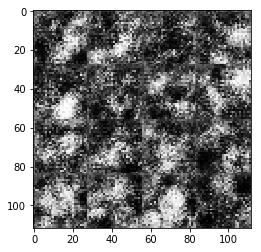

discriminator loss:  1.00794 generator loss:  0.692084


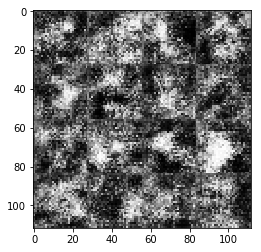

discriminator loss:  1.00787 generator loss:  0.692151


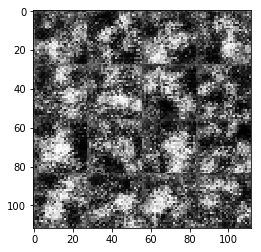

discriminator loss:  1.00801 generator loss:  0.692216


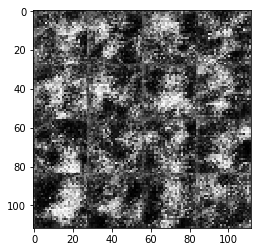

discriminator loss:  1.00846 generator loss:  0.69185


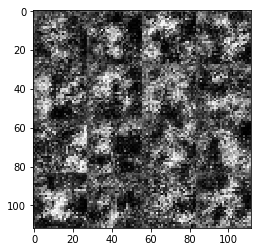

discriminator loss:  1.00995 generator loss:  0.690922


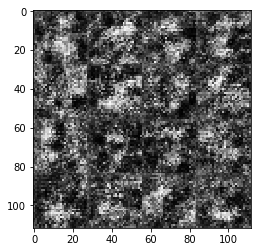

discriminator loss:  1.39952 generator loss:  0.606973


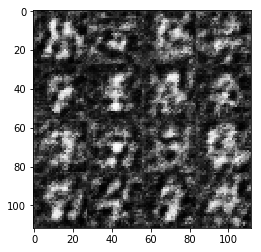

discriminator loss:  1.3872 generator loss:  0.692313


In [ ]:
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)